In [1]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore')

In [2]:
def read_df(input_file):
    return pd.read_csv(input_file, index_col='test_number')

This csv contains metrics for the blosc codecs from the numcodecs package. Input data was 20 random (1024,1024,1024) blocks from the least-compressible tile (tile_x_0015_y_0000_z_0000_ch_488.ims) of the exaSPIM_609281 dataset. Blocks are read from the Imaris file on the Vast storage server, compressed and written to GCS and AWS S3

Test machine: camerona-vm1

In [3]:
filepath =  "../data/blosc_metrics_exaSPIM_609281.csv"
df = read_df(filepath)

In [4]:
def plot_ratios(df, y_labels, title):
    """adapted from http://alimanfoo.github.io/2016/09/21/genotype-compression-benchmark.html"""
    fig, ax = plt.subplots(figsize=(7, df.shape[0] * .25))
    ax.barh(y=np.arange(df.shape[0]), width=df['storage_ratio'].tolist(), height=.8)
    ax.set_yticks(np.arange(df.shape[0]) + .4)
    data = []
    for l in y_labels:
        data.append(df[l])
    ax.set_yticklabels(df[y_labels].apply(tuple, axis=1))
    ax.set_ylabel(", ".join(y_labels))
    ax.grid(axis='x')
    ax.set_xlabel('Storage ratio')
    ax.autoscale(axis='y')
    ax.set_title(title, va='bottom')
    
def plot_speed(df, y_labels, title):
    """adapted from http://alimanfoo.github.io/2016/09/21/genotype-compression-benchmark.html"""
    fig, ax = plt.subplots(figsize=(7, df.shape[0] * .25))
    x = df['compress_bps'] / (2**20)  # MiB/s
    ax.barh(y=np.arange(df.shape[0]), width=x, height=.8)
    # plot data points
    y = np.arange(df.shape[0]) + .4
    ax.plot(x, y, marker='o', linestyle=' ', color='k', markersize=2)
    ax.set_yticks(np.arange(df.shape[0]) + .4)
    ax.set_yticklabels(df[y_labels].apply(tuple, axis=1))
    ax.set_ylabel(", ".join(y_labels))
    ax.grid(axis='x')
    ax.set_xlabel('Speed (MiB/s)')
    ax.autoscale(axis='y', tight=True)
    ax.set_title(title, va='bottom')
    for i, (xi, ri) in enumerate(zip(x, df['storage_ratio'])):
        ax.annotate('%.1fX' % ri, xy=(xi, i + .4), xytext=(5, 0),
                    textcoords='offset points', ha='left', va='center',
                    fontsize=8)

In [5]:
y_labels = ['compressor_name', 'shuffle', 'level']
# Take the mean over all tiles
g = df.groupby(y_labels).mean().reset_index()

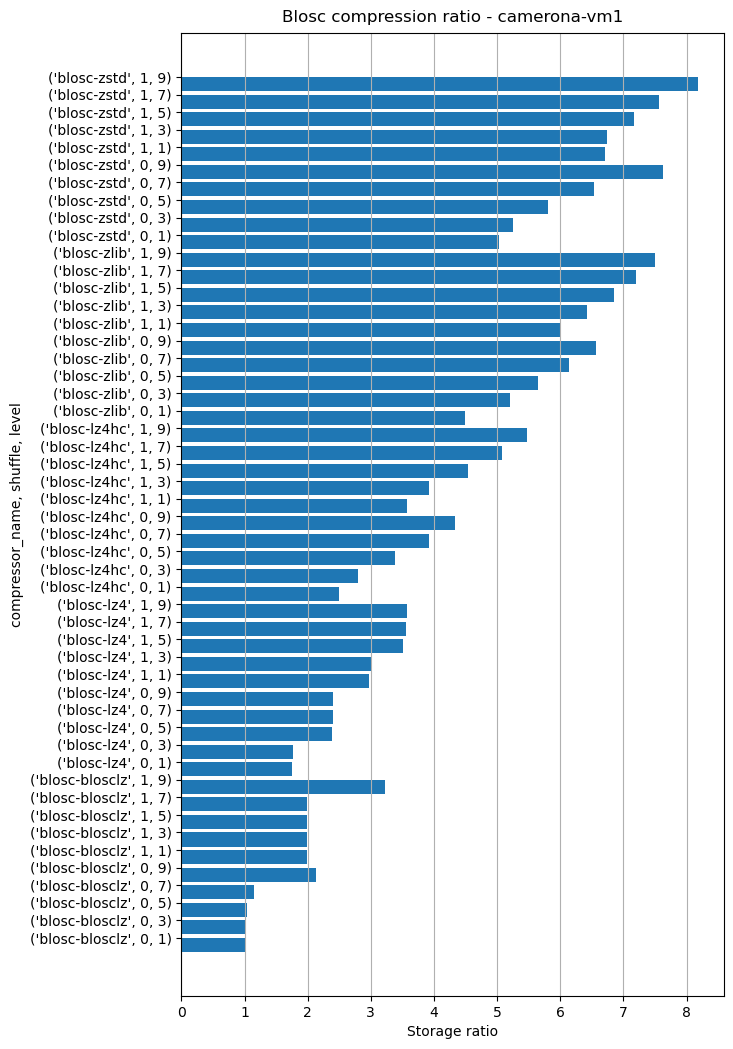

In [6]:
plot_ratios(g, y_labels, f"Blosc compression ratio - camerona-vm1")

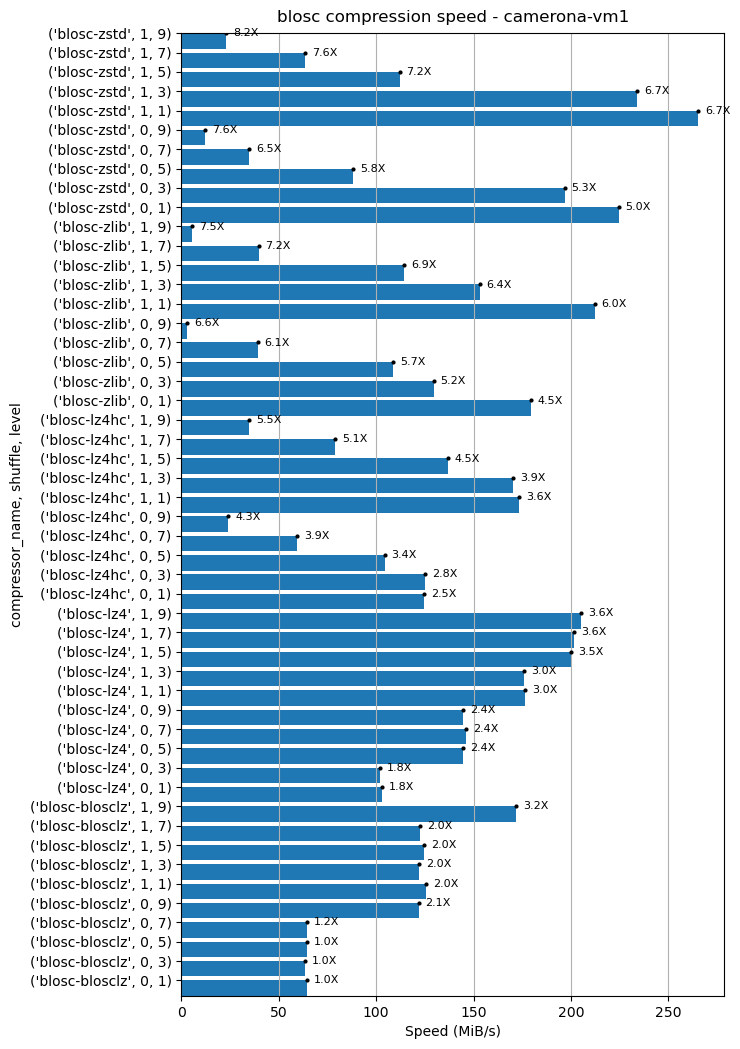

In [7]:
plot_speed(g, y_labels, f"blosc compression speed - camerona-vm1")

In [8]:
import seaborn as sns

def plot_blosc_summary(df, title=None, alpha=1):
    """adapted from http://alimanfoo.github.io/2016/09/21/genotype-compression-benchmark.html"""
    from matplotlib.offsetbox import AnchoredText
    
    fig, ax = plt.subplots(figsize=(7, 7), dpi=300)
    sns.despine(ax=ax, offset=10)
    if title:
        ax.set_title(title, va='bottom')
    
    mdf = df.groupby(['compressor_name', 'level', 'shuffle']).median().reset_index()
    annotate = mdf.index[(mdf.compressor_name == 'blosc-zstd') & (mdf.shuffle == 1) & (mdf.level == 1)].tolist()
    
    x = mdf['compress_bps'] / 2**20
    y = mdf['storage_ratio']
    s = mdf['level'].to_numpy() * 20
    
    compressors = mdf['compressor_name']
    
    palette = sns.color_palette('Set1', n_colors=5)
    colors = np.array([
        palette[0] if c == 'blosc-blosclz'
        else palette[1] if c == 'blosc-lz4'
        else palette[2] if c == 'blosc-lz4hc'
        else palette[3] if c == 'blosc-zlib'
        else palette[4] if c == 'blosc-zstd'
        else 'k'
        for c in compressors
    ])
    
    is_bitshuffle = (mdf['shuffle'] == 1)
    bs_marker = 'h'
    ns_marker = 'o'
    ax.scatter(x[is_bitshuffle], y[is_bitshuffle], s[is_bitshuffle], color=colors[is_bitshuffle], 
               marker=bs_marker, alpha=alpha)
    ax.scatter(x[~is_bitshuffle], y[~is_bitshuffle], s[~is_bitshuffle], color=colors[~is_bitshuffle], 
               marker=ns_marker, alpha=alpha)
    
    ax.set_title(title)
    ax.set_xlabel('Avg. Write Speed (MiB/s)')
    ax.set_ylabel('Avg. Storage Ratio')
    at = AnchoredText(
    "N blocks = 20\nblock size = 2GiB", prop=dict(size=12), frameon=True, loc='upper right'
    )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    for i, (xi, yi, c) in enumerate(zip(x, y, mdf['compressor_name'])):
        if i in annotate:
            ax.annotate('%s, level=%s, %s' % (
                mdf.iloc[i]['compressor_name'],
                mdf.iloc[i]['level'],
                'shuffle' if mdf.iloc[i]['shuffle'] == 1 else 'no shuffle'
                
            ), 
            xy=(xi, yi), xytext=(25, 0), va='center', ha='left', 
            textcoords='offset points', arrowprops=dict(arrowstyle="wedge"), fontsize=8)
    
    # color legend
    import matplotlib.lines as mlines
    handles = [
        mlines.Line2D([], [], color=color, marker=ns_marker, linestyle=' ',
                      markersize=10, label=label, alpha=alpha)
        for color, label in zip(
            palette,
            ['blosc+blosclz', 'blosc+lz4', 'blosc+lz4hc', 'blosc+zlib', 'blosc+zstd']
        )
    ]
    handles += [
        mlines.Line2D([], [], color='k', marker=ns_marker, linestyle=' ',
                      markersize=10, label='NOSHUFFLE', alpha=alpha),
        mlines.Line2D([], [], color='k', marker=bs_marker, linestyle=' ',
                      markersize=10, label='SHUFFLE', alpha=alpha)
        
    ]
    handles += [
        mlines.Line2D([], [], color='k', marker=ns_marker, linestyle=' ',
                      markersize=np.sqrt(x * 20), label='level %s' % x, alpha=alpha)
        for x in df['level'].unique().tolist()
        
    ]
    ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(1, 0), ncol=2)
    ax.grid(axis='both')
    ax.set_yticks(np.arange(12))
    
    
def plot_lossless_summary(df, title=None, alpha=1):
    """adapted from http://alimanfoo.github.io/2016/09/21/genotype-compression-benchmark.html"""
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.despine(ax=ax, offset=10)
    if title:
        ax.set_title(title, va='bottom')
        
    mdf = df.groupby(['compressor_name', 'level']).median().reset_index()
    std_df = df.groupby(['compressor_name', 'level']).std().reset_index()
    
    x = mdf['compress_bps'] / 2**20
    y = mdf['storage_ratio']
    s = mdf['level'].to_numpy() * 20
    yerr = std_df['storage_ratio']
    xerr = std_df['compress_bps']
    
    compressors = mdf['compressor_name']
    
    palette = sns.color_palette('Set1', n_colors=4)
    colors = np.array([
        palette[0] if c == 'lossless-zlib'
        else palette[1] if c == 'lossless-gzip'
        else palette[2] if c == 'lossless-bz2'
        else palette[3] if c == 'lossless-lzma'
        else 'k'
        for c in compressors
    ])
    
    ax.scatter(x, y, s, color=colors, marker='o', alpha=alpha)
    ax.set_title(title)
    ax.set_xlabel('Avg. Write Speed (MiB/s)')
    ax.set_ylabel('Avg. Storage Ratio')
    
        # color legend
    import matplotlib.lines as mlines
    handles = [
        mlines.Line2D([], [], color=color, marker='o', linestyle=' ',
                      markersize=10, label=label, alpha=alpha)
        for color, label in zip(
            palette,
            ['zlib', 'gzip', 'bz2', 'lzma']
        )
    ]
    handles += [
        mlines.Line2D([], [], color='k', marker='o', linestyle=' ',
                      markersize=np.sqrt(x * 20), label='level %s' % x, alpha=alpha)
        for x in df['level'].unique().tolist()
        
    ]
    ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(1, 0), ncol=2)
    ax.grid(axis='both')
    
    

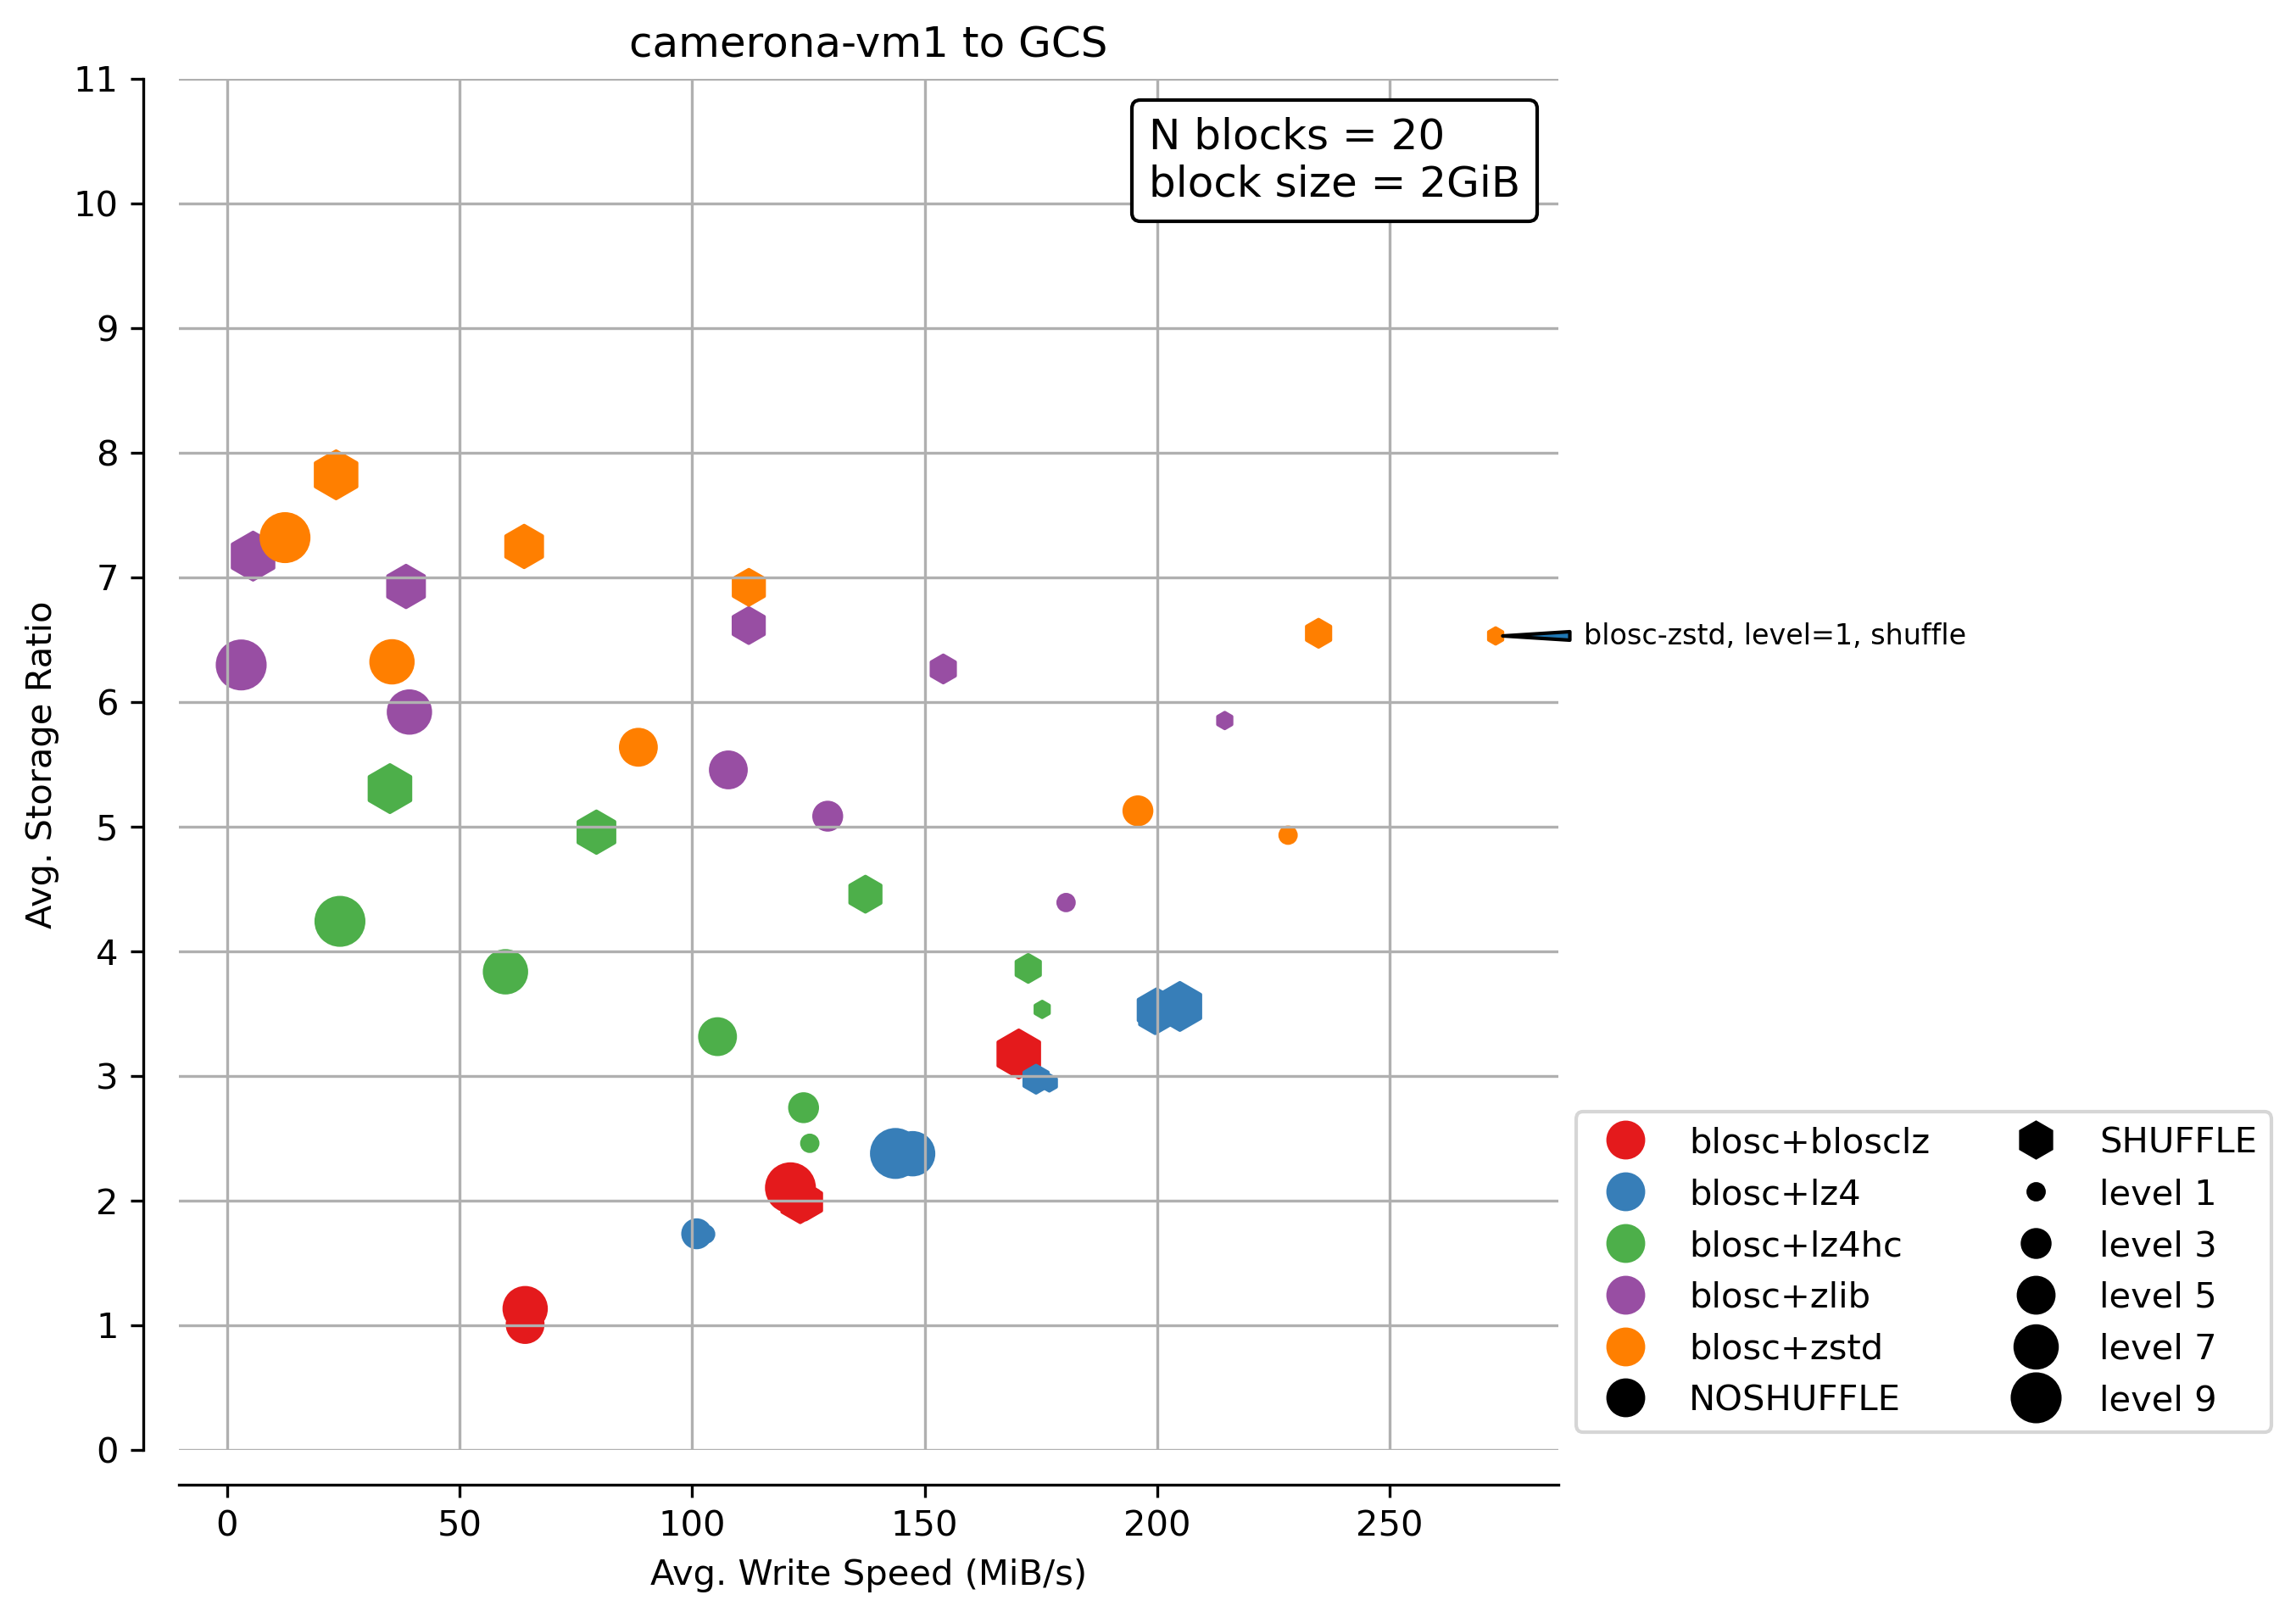

In [9]:
plot_blosc_summary(df, "camerona-vm1 to GCS")

Text(0.5, 1.0, 'VAST to S3 Write Speed (MiB/s)')

<Figure size 6400x4800 with 0 Axes>

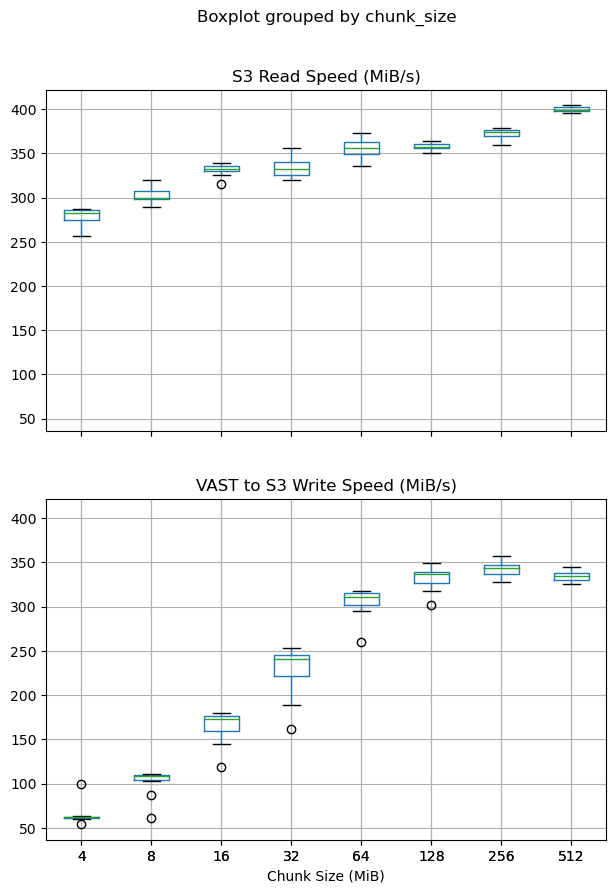

In [10]:
df = read_df("../data/chunksize-metrics-exaSPIM.csv")
df['chunk_size'] = df['chunk_size'].astype(int) / (2**20)
df['chunk_size'] = df['chunk_size'].astype(int)
df['read_mbps'] = df['read_bps'] / (2**20)
df['write_mbps'] = df['write_bps'] / (2**20)
fig = plt.figure(dpi=1000)
ax = df.drop(
    ['write_time', 'read_time', 'read_bps', 'write_bps'], 
    axis=1
).boxplot(by="chunk_size", figsize=(7,10), layout=(2,1))
ax[0].set_xlabel("Chunk Size (MiB)")
ax[0].set_title("S3 Read Speed (MiB/s)")
ax[1].set_xlabel("Chunk Size (MiB)")
ax[1].set_title("VAST to S3 Write Speed (MiB/s)")